In [1]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np 

import torch
import nrrd
import matplotlib.pyplot as plt
import json
import itertools
from matplotlib.patches import Rectangle
from sklearn.metrics import classification_report

from torchvision.ops import nms

import matplotlib.patches as mpatches

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import classification_report, confusion_matrix

from utils import remove_labels
from visualization import *
from evaluation import *
from utils import *
from nets.segmentation import FasterRCNN
from loaders.tt_dataset import TTDatasetBX,TTDataModuleBX, BBXImageTrainTransform, BBXImageEvalTransform, BBXImageTestTransform

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
ckpt = '/CMF/data/lumargot/trachoma/output/object_detection/new_labels_corrected/epoch=9-val_loss=1.73.ckpt'
model = FasterRCNN.load_from_checkpoint(ckpt, strict=False)

In [4]:
mount_point = "/CMF/data/lumargot/trachoma/"

df_train = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_test.csv')


concat_labels=['overcorrection', 'ECA', 'Gap', 'Fleshy']
drop_labels = ['Short Incision', 'Reject']
img_column= "filename" 
class_column = 'class'
label_column = 'label'
# map = {0:'Reject', 1:'Healthy', 2:'Bad'}

map = {0:'Reject', 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}


In [5]:

df_test = remove_labels(df_test, class_column, label_column, drop_labels, concat_labels)
df_train = remove_labels(df_train, class_column, label_column, drop_labels, concat_labels)
df_val = remove_labels(df_val, class_column, label_column, drop_labels, concat_labels)

print(df_train[['label', 'class']].value_counts())

df_train = df_train.loc[~ df_train['label'].isin(['Reject'])]
df_val = df_val.loc[~ df_val['label'].isin(['Reject'])]
df_test = df_test.loc[~ df_test['label'].isin(['Reject'])]

label           class
Healthy         1        18583
overcorrection  3         3497
Entropion       2         2502
Gap             3          763
ECA             3          603
Fleshy          3          451
dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
ttdata = TTDataModuleBX(df_train, df_val, df_test, batch_size=1, num_workers=2, img_column='filename', mount_point=mount_point, 
                        train_transform=BBXImageTrainTransform(), valid_transform=BBXImageEvalTransform(), test_transform=BBXImageTestTransform())
ttdata.setup()
dataload = ttdata.test_dataloader()
ds = ttdata.test_ds

# Prediction

In [ ]:
model.eval()

num_preds,num_fps,num_fns = 0, 0, 0
l_ious, l_distances = [], []
l_distances = []
gt, pred = [], []
data_out = {}

gt_eye, pred_eye = [], []
for idx, batch in enumerate(tqdm(dataload)):
    
  targets = batch
  imgs = targets.pop('img', None)
  outs = model(imgs, mode='test')
  out_img = outs[0]

  eyelid_seg = select_eyelid_seg(targets['mask'][0])
  # remove boxes outside segmentation mask 
  preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.5)

  # remove overlapping boxes with iou > 0.7  
  pred_indices = nms(preds['boxes'], preds['scores'], iou_threshold=.7) ## iou as args
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=1.0) ## iou as args

  filename = ds.data.df_subject.iloc[idx]['filename']

  preds = filter_targets_indices(preds, pred_indices, detach=True)

  targets['boxes'] = targets['boxes'][0,gt_indices].cpu().detach()
  targets['labels'] = targets['labels'][0,gt_indices].cpu().detach()

  n_p, n_fp, n_fn, i, d, gt_ix, pred_idx = evaluate_with_fp_fn(targets['boxes'], preds['boxes'])

  gt_eye.append(gt_eye_outcome(targets['labels']))
  pred_eye.append(eye_level_outcome(preds['labels']))

  gt.append(targets['labels'][gt_ix])
  pred.append(preds['labels'][pred_idx])

  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))
  l_distances.append(torch.tensor(d))

ious = torch.cat(l_ious, dim=0)
dist = torch.cat(l_distances, dim=0)

pred = torch.cat(pred)
gt = torch.cat(gt)


total_detections = num_preds + num_fns + num_fps
out_dict = {'Matched Prediction': num_preds,
            'Ratio match prediction': 100*num_preds/total_detections, 
            'False Positives':num_fps,
            'Ratio FP': 100*num_fps/total_detections, 
            'False Negatives':num_fns,
            'Ration FN': 100*num_fns/total_detections, 
            'Mean IoU': ious.mean().item(),
            }
print(json.dumps(out_dict, indent=2))


  7%|▋         | 44/662 [00:03<00:35, 17.30it/s]

the segmentation is probably off


 34%|███▍      | 228/662 [00:18<00:35, 12.10it/s]

the segmentation is probably off


 47%|████▋     | 314/662 [00:25<00:27, 12.67it/s]

the segmentation is probably off
the segmentation is probably off


 49%|████▊     | 322/662 [00:26<00:27, 12.18it/s]

the segmentation is probably off


 50%|████▉     | 330/662 [00:26<00:28, 11.76it/s]

the segmentation is probably off


100%|██████████| 662/662 [02:23<00:00,  4.61it/s]

{
  "Matched Prediction": 5940,
  "Ratio match prediction": 40.35874439461883,
  "False Positives": 8778,
  "Ratio FP": 59.64125560538117,
  "False Negatives": 0,
  "Ration FN": 0.0,
  "Mean IoU": 0.6851743511982843
}


## Eye level evaluation

-1 indicates a conflict: same number of labels for either Entropion or Overcorrection

              precision    recall  f1-score   support

          -1       0.22      0.15      0.18        61
           1       0.48      0.26      0.34       203
           2       0.38      0.71      0.50       144
           3       0.67      0.64      0.66       254

    accuracy                           0.49       662
   macro avg       0.44      0.44      0.42       662
weighted avg       0.51      0.49      0.48       662

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.43967258606170556


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


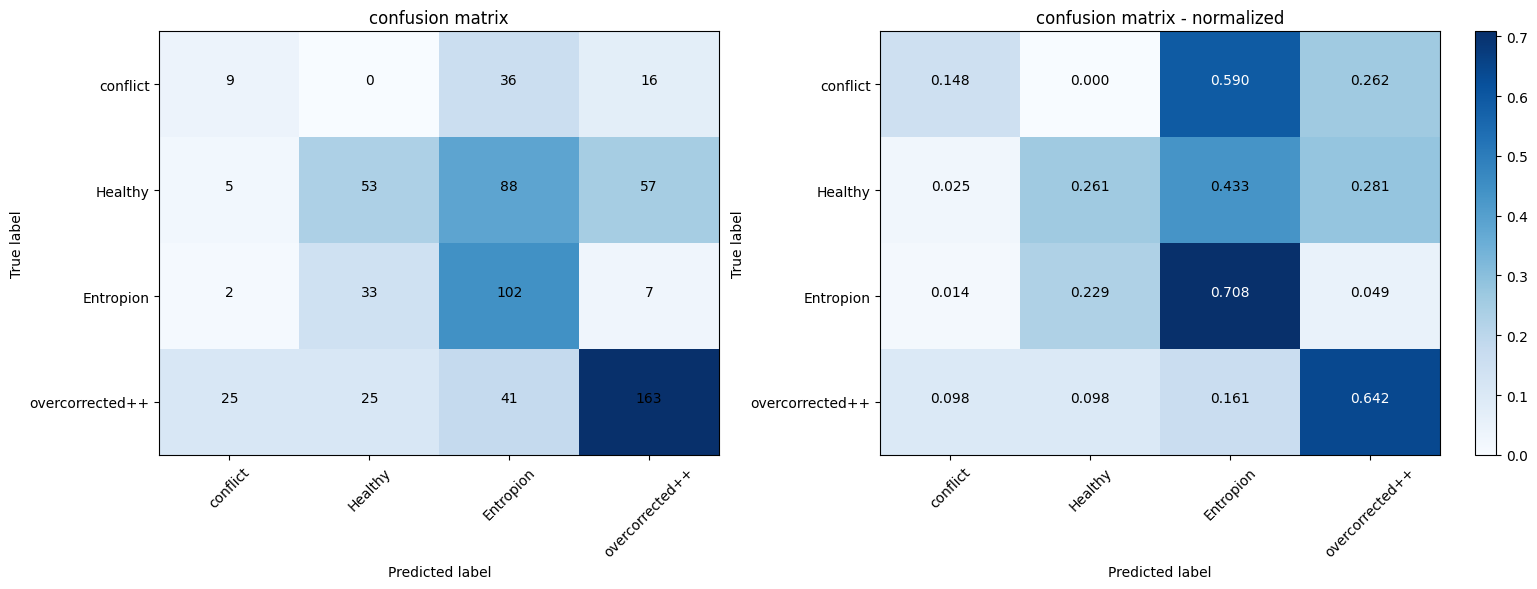

In [15]:
class_names = ['conflict','Healthy','Entropion','overcorrected++']
print(classification_report(gt_eye, pred_eye))
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
cnf_matrix = confusion_matrix(gt_eye, pred_eye)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
plt.show()

## Box level evaluation

              precision    recall  f1-score   support

           1       0.81      0.73      0.77      3795
           2       0.52      0.63      0.57       699
           3       0.59      0.67      0.63      1446

    accuracy                           0.70      5940
   macro avg       0.64      0.68      0.65      5940
weighted avg       0.72      0.70      0.71      5940

Confusion matrix, without normalization


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


Normalized confusion matrix, avg: 0.6767658044128618


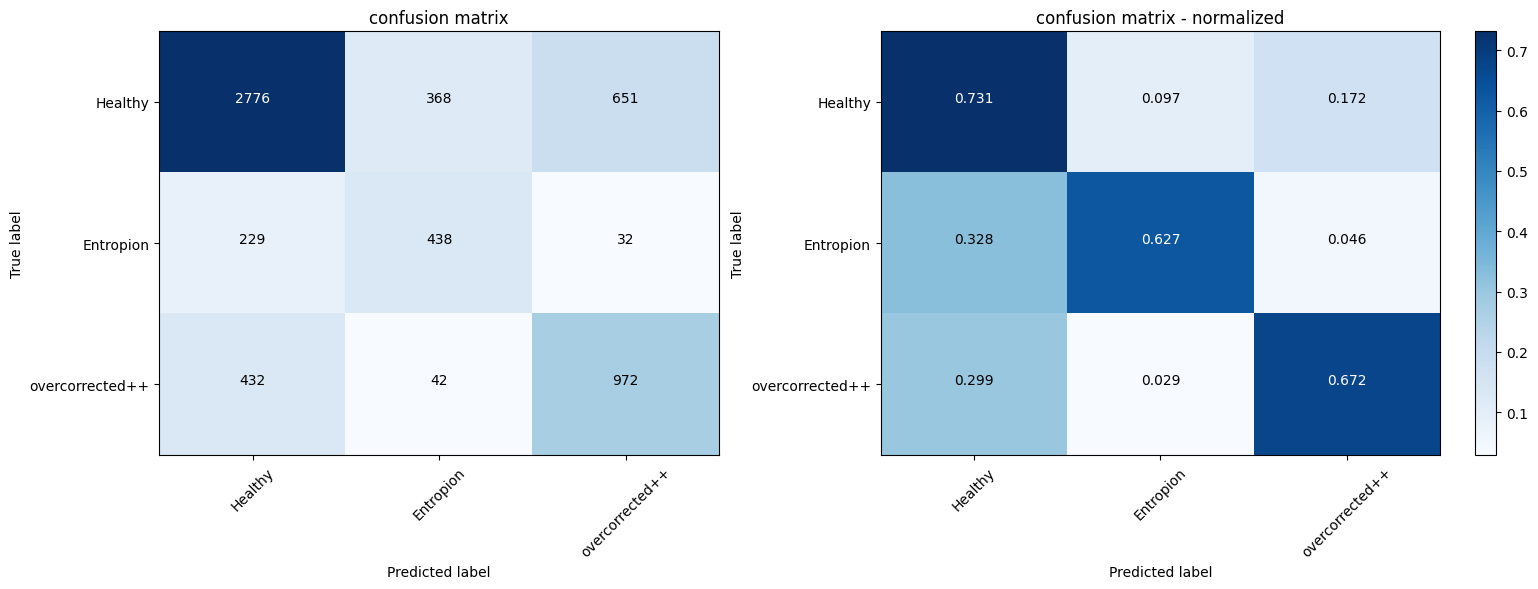

In [16]:
df_pret = pd.DataFrame(data={'gt':gt, 'pred':pred})
print(classification_report(df_pret['gt'], df_pret['pred']))

class_names = ['Healthy','Entropion','overcorrected++']
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_pret['gt'], df_pret['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
plt.show()


## Inputs

In [ ]:
out_dir = '/CMF/data/lumargot/trachoma/output/tmp/'
for IDX, batch in enumerate(tqdm(dataload)):
  if IDX <1:
    pass
  else:
    targets = batch
    imgs = targets.pop('img', None)
    outs = model(imgs, mode='test')
    out_img = outs[0]

    img = imgs[0].permute(1,2,0)
    eyelid_seg = select_eyelid_seg(targets['mask'][0])
    
    ## targets
    gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=1.0) ## iou as args
    targets = convert_targets_numpy(targets)
    targets = filter_targets_indices(targets, gt_indices)

    if gt_eye_outcome(targets['labels']) == 1:

      plt.figure(figsize=(20,5))
      plt.subplot(131)
      plot_patches(img, targets, map=map, title='Annotations')


      ## predictions 
      # remove overlapping boxes with iou > 0.7
      preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.5)
      plt.subplot(132)
      out_img = convert_targets_numpy(out_img)
      legend_patches = [mpatches.Patch(color=np.array(color)/255, label=name) for name, color in colormap.items()]
      plot_patches(img, out_img, map=map, title=f'Raw output')

      plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
      plt.tight_layout()


      ## post-processing
      
      # remove boxes outside segmentation mask 
      pred_indices = nms(preds['boxes'], preds['scores'], iou_threshold=.7) ## iou as args
      preds = filter_targets_indices(preds, pred_indices, detach=True)

      outcome = eye_level_outcome(preds['labels'])
      map_outcome = {-1: 'Conflict', 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}

      plt.subplot(133)
      filled_targets = fill_empty_patches(preds)
      filled_targets = replace_sandwiched_labels(filled_targets)
      overlay, masked_overlay = create_mask(eyelid_seg, filled_targets)
      result = add_mask_countours(img, overlay)
      
      plt.imshow(result)
      plt.title(f"post-processing --  {map_outcome[outcome]}")

      # plot_patches(img, filled_targets, map=map, title=f'post-processing {map_outcome[outcome]}')

      plt.tight_layout()

      plt.show()
      plt.close()

  if  IDX == 100:
    break

other idea, from the mask and the boxes, compute the percentage of overlap with the mask per label. if bad outcomes are too little -> discard. Similar to dropping labels if too little, except more modular